# Compte rendu de TP du 27/03 - Introduction LBM
## Théo Duez

### Importation des librairies

In [1]:
using LinearAlgebra    # For matrix computations
using Plots            # For plotting
using LaTeXStrings     # For writing LaTeX in code
using Interpolations   # For computing interpolation, useful for animation

### Code de simulation

On reprend le code écrit dans le TP1 en rajoutant l'entrée `collisision!` à la fonction principale `solve`. Cette nouvelle entrée est ue fonction qui réalisera les conditons de bord juste avant le streaming.

In [2]:
# Initialisation
m_init(u₀::Vector, ϕ::Base.Callable) = transpose(hcat(u₀, equilibrium(u₀, ϕ)))
f_init(m::AbstractMatrix, λ::Real) = m2f(m,λ)

# Moment matrix
M(λ::Real) = [1 1; -λ λ]
Minv(λ::Real) = [0.5 -0.5*(1.0/λ); 0.5 0.5*(1.0/λ)]

# Conversion to moment
f2m(f::AbstractMatrix, λ::Real) = reduce(hcat, [M(λ) * f[:,i] for i in axes(f)[2]])
m2f(m::AbstractMatrix, λ::Real) = reduce(hcat, [Minv(λ) * m[:,i] for i in axes(m)[2]])
f2m!(m::AbstractMatrix, f::AbstractMatrix, λ::Real) = m .= reduce(hcat, [M(λ) * f[:,i] for i in axes(f)[2]])
m2f!(f::AbstractMatrix, m::AbstractMatrix, λ::Real) = f .= reduce(hcat, [Minv(λ) * m[:,i] for i in axes(m)[2]])

# Equilibrium
equilibrium(m₀::Vector, ϕ::Base.Callable) = ϕ.(m₀)

# Relaxation
function relaxation!(m::AbstractMatrix, s₁::Real, ϕ::Base.Callable)
    @inbounds m[1,:] .= m[1,:]
    @inbounds m[2,:] .= m[2,:] .+ s₁ .* (equilibrium(m[1,:], ϕ) .- m[2,:])
end

# Streaming
function streaming!(f::AbstractMatrix)
    @inbounds f[1,1:end-1] .= f[1,2:end]
    @inbounds f[2,2:end]   .= f[2,1:end-1]
end

# Compute the dynamics
function solve(u₀fun::Base.Callable, ϕ::Base.Callable; Nₜ::Int = -1, T::Real, Nₓ::Int, xmax::Real, xmin::Real, s::Real, λ::Real = -1, collision!::Base.Callable)

    # INPUTS
    #   - u₀fun         : Function of space that gives the initial condition,
    #   - ϕ             : Function related to the equation we want to simulate,
    #   - Nₜ             : Number of timestep,
    #   - T             : Endtime of the solution computed,
    #   - Nₓ            : Number of point in the mesh
    #   - xmax          : Right edge of the space domain,
    #   - xmin          : Left edge of the space domain,
    #   - s             : Parameter of relaxation 
    #   - λ             : Speed of the lattice
    #   - collision!    : Function to perform the collision on the edge of the domain,

    # OUTPUTS
    #   - A solution u through time on the domain [xmin,xmax]x[0,T] of the equation 
    #                       ∂ₜu + ∂ₓφ(u) = 0

    # Parameters of the simulation
    @assert max(Nₜ, λ) > 0
    @assert min(Nₜ, λ) < 0

    Δx = (xmax - xmin)/(Nₓ+1)
    if λ > 0
        _λ = λ
        Δt = Δx/_λ
        Nₜ = Int(round(T/Δt))
        T = Δt * Nₜ
    else 
        Δt = T/Nₜ
        _λ = Δx/Δt
    end
   
    # Mesh
    mesh = LinRange(xmin-0.5*Δx,xmax+0.5*Δx,Nₓ+2)

    # Initialisation 
    u₀ = u₀fun(mesh)
    m = m_init(u₀, ϕ)
    f = f_init(m, _λ)

    # Storage for the solution
    sol = zeros(Nₜ+1,Nₓ)
    sol[1,:] = m[1,2:end-1]
    
    # Loop for each timestep
    for i in 1:Nₜ
        relaxation!(m, s, ϕ)
        m2f!(f, m, _λ)
        collision!(f, λ, c)
        streaming!(f)
        f2m!(m, f, _λ)
        sol[i+1,:] =  m[1,2:end-1]
    end
    λ > 0 ? (sol,T) : sol
end

solve (generic function with 1 method)

### Condition initiale

On reprend également le code permettant de générer la condition initiale nulle en dehors d'un compact, positive, symétrique, valant 1 en son centre de symétrie et de régularité voulue par l'utilisateur.

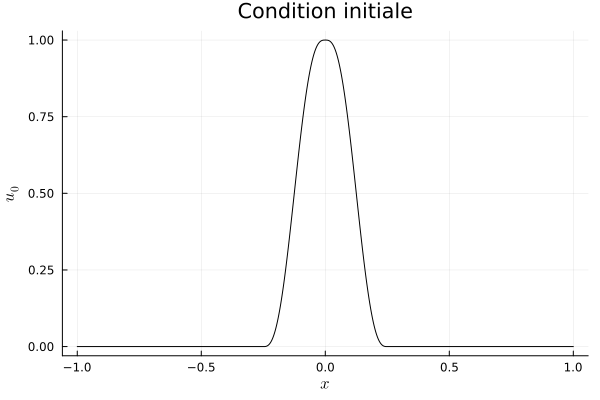

In [28]:
function u_init(X::AbstractVector, reg::Int, middle::Real, swidth::Real)

    # Parameters to localise the bump part
    xmin, xmax = min(X...), max(X...)
    width = swidth*(xmax - xmin)
    x_left, x_right = middle - width, middle + width

    # Array to store the output
    output = zero(X)

    ind_l = findall(x -> x > x_left && x <= middle, X)
    ind_r = findall(x -> x < x_right && x > middle, X)

    x_sl = (X[ind_l] .- x_left .- 0.5 * width) ./ (0.5 * width)
    x_sl_k = copy(x_sl)
    x_sl .= x_sl.^2
    x_sr = (X[ind_r] .- middle .- 0.5 * width) ./ (0.5 * width)
    x_sr_k = copy(x_sr)
    x_sr .= x_sr.^2

    cte = 0.0
    for k in 0:reg
        coeff = (-1)^k * binomial(reg, k) / (2 * k + 1)   # binomial is an inbuilt function in Julia
        output[ind_l] .+= coeff .* x_sl_k
        output[ind_r] .-= coeff .* x_sr_k
        cte += coeff
        x_sl_k .*= x_sl
        x_sr_k .*= x_sr
    end
    output[ind_l] .+= cte
    output[ind_r] .+= cte
    output ./= 2 * cte

    output
end

# Plot of an example of the initial condition
plot(LinRange(-0.5,0.5,1000), u_init(collect(LinRange(-0.5,0.5,1000)), 2, 0.0, 0.125), legend=:false, c=:black)
xlabel!(L"x")
ylabel!(L"u_0")
title!("Condition initiale")

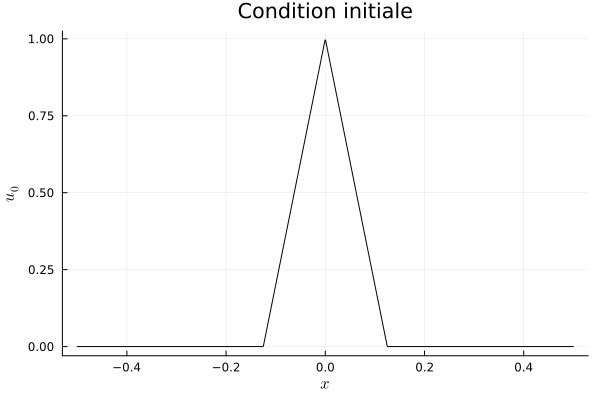

In [29]:
function solution_adimensionnee(X::AbstractVector, t::Real)
    #=
    A normalized hat solution of the Burgers equation starting from the following initial condition
                                /\                      y=1
                               /  \
                              /    \
           __________________/      \__________________ y=0
                        x=  -1  0    1
    computed on the domain defined by X 
    =#

    Y = zeros(size(X))
    if t < 0
        return y
    elseif t < 1
        xᵢ = t
        indr = findall(x -> x ≥ t && x < 1, X)
        Y[indr] = 1 .- 1/(1-t) .* (X[indr] .- t)
    else
        xᵢ = 2*sqrt(.5*(1+t))- 1
    end
    indl = findall(x -> x ≥ -1 && x ≤ xᵢ, X)
    Y[indl] = 1/(1+t).* (1 .+ X[indl])
    Y
end

function solution(x::AbstractVector, t::Real; ymax::Real = 1, middle::Real, width::Real)
    # INPUTS
    #   - x         : Mesh of the domain
    #   - t         : Time
    #   - ymax      : Height of the intitial condition
    #   - middle    : Center of the initial condition
    #   - width     : Widhth of the initial condition

    # OUTPUTS
    #   -   Hat solution of the Burgers equation with a height of ymax at instant t on the domain defined by the mesh x
    ymax*solution_adimensionnee(1/width*(x .- middle), ymax/width*t)
end

# Plot of an example of the initial condition
plot(LinRange(-0.5,0.5,1000), solution(collect(LinRange(-0.5,0.5,1000)), 0.0; middle = 0.0, width = 0.125), legend=:false, c=:black)
xlabel!(L"x")
ylabel!(L"u_0")
title!("Condition initiale")

### Animation

Le code suivant permettra de générer des animations de nos solutions au cours du temps.

In [4]:
function animation(sol::AbstractMatrix; d::Real = 5, fps::Int = 30, Lmax::Real, Lmin::Real, T::Real, label::String = "")

    # INPUTS
    #   - sol       : Solution Matrix given by the dynamics function,
    #   - d         : Duration wanted for the animation,
    #   - fps       : Number of frame per secondes,
    #   - Lmax      : Number of frame per secondes,
    #   - Lmin      : Number of frame per secondes,
    #   - T         : Final to time of the simulation to print the current physical time,
    #   - label     : Label to add to the animation

    # OUTPUTS
    #   - An animation of the solution through the time
    
    # Total frame
    nbframe = fps * d
  
    # Time and space vector
    Nₜ, Nₓ = size(sol)
    time = range(0,1,Nₜ)
    mesh = LinRange(Lmin,Lmax,Nₓ)
    
    # Constante to fix the yaxis
    M = max(sol...)
    m = min(sol...)

    anim = @animate for n in 1:nbframe
        # Actual frame
        t = n / (fps*d)
        # Interpolation
        interp= [linear_interpolation(time, sol[:,i])(t) for i in 1:Nₓ]
        # Plots
        plot(mesh, interp, ylim = [m*1.1^sign(-m),M*1.1^sign(M)], c = :black, label = label)
        xlabel!(L"x")
        ylabel!(L"u")
        title!("t = "*string(round(t*T; digits = 3)))
    end
  
    gif(anim, fps = fps)
  end

animation (generic function with 1 method)

## **Exercice 1 : Equation d'advection**

Dans cette partie, on se concentre sur l'équation d'advection.

In [5]:
# Advection
advection(u::Real, c::Real) = c*u

advection (generic function with 1 method)

### **1. Condition périodique**

Introduisons la fonction qui permet d'effectuer la condition périodique.

In [22]:
function periodic!(f::AbstractMatrix, λ::Real, c::Real)
    f[1,end] = f[1,2]
    f[2,1]   = f[2,end-1]
end

periodic! (generic function with 1 method)

Affichons une animation pour visualiser les effets de cette condition périodique.

In [ ]:
# Initial condition
center = 0.0
width = 0.125
u₀fun(x) = u_init(x, 2, center, width ) 

# Parameters
xmax = 0.5
xmin = -0.5
c = 0.5
Tf = 2.0  
Nₓ = 100
Nₜ = 150
s = 2.0

# Computation of the solutions
sol = solve(u₀fun, x -> advection(x, c); Nₜ = Nₜ, T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, collision! = periodic!)

# Creation of the animation
animation(sol; d = 10, fps = 10, Lmax = xmax, Lmin = xmin, T = Tf, label = "Cond Périodique")

On remarque que la solution se comporte vraiment de façon périodique : la solution se propage comme si elle se propageait en ligne droite sans condition aux bords sur un plus long domaine. 

Observons ce qui se passe pour différentes valeurs de $s$ et de $\lambda$.

In [ ]:
# Initial condition
center = 0.0
width = 0.125
u₀fun(x) = u_init(x, 2, center, width)  

# Parameters
xmax = 0.5
xmin = -0.5
c = 0.5
Tf = 2.0 
Nₓ = 256
s = 1.0
λ = 1.0
Δx = (xmax - xmin)/(Nₓ+1)
mesh = LinRange(xmin+0.5*Δx,xmax-0.5*Δx,Nₓ)

Array_s = Array_s = [0.5, 1.0, 1.5, 2.0]
Array_λ = [0.5, 1.0, 2.0]

# Resolution
sol_s = [solve(u₀fun, x -> advection(x, c); Nₜ = Nₜ = Int(Tf *Nₓ*λ), T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, collision! = periodic!) for s ∈ Array_s]
sol_λ = [solve(u₀fun, x -> advection(x, c); Nₜ = Nₜ = Int(Tf *Nₓ*λ), T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, collision! = periodic!) for λ ∈ Array_λ]

# Plot

plt_λ = plot(mesh, u₀fun(mesh), label ="init", size = (900,400), c=:black, ylim = [-0.2, 1.1])
xlabel!(L"x")
ylabel!(L"u")
title!("λ = "*string(λ))
for i in eachindex(sol_s)
    scatter!(mesh, sol_s[i][end,:], label = "s = "*string(Array_s[i]), markershape=:circle, ma = 0.5,)
end

plt_s = plot(mesh, u₀fun(mesh), label ="init", size = (900,400), c=:black, ylim = [-0.2, 1.1])
xlabel!(L"x")
ylabel!(L"u")
title!("s = "*string(s))
for i in eachindex(sol_λ)
    scatter!(mesh, sol_λ[i][end,:], label = "λ = "*string(Array_λ[i]), markershape=:circle, ma = 0.5)
end

plot(plt_λ, plt_s, layout = (1,2), size = (1200,500), color = :red, margin = 0.5Plots.cm)

Sans grande surprise, le comportement est similaire à celui sans condition de bords. On peut toutefois se demander si la condition périodique ne réduit pas l'ordre de convergence. Par exemple, si la condtion périodique est une approximation à l'ordre 1, alors il y aura réduction de la convergence d'ordre 2 fournit dans le cas $s=2$.

In [ ]:
# Initial condition
center = 0.0
width = 0.125
u₀fun(x) = u_init(x, 2, center, width)  

# Parameters
xmax = 0.5
xmin = -0.5
c = 0.5
Tf = 2.0 
λ = 0.6

# Different value of s
Array_s = Array_s = [0.5, 1.0, 1.5, 2.0]

# Variation of the parameter $Δx$ : 
pNₓ= range(3,9)
base = 2.0
ArrayNₓ = Int.(round.( base  .^ pNₓ))

# Resolution
Arraysol = [[solve(u₀fun, x -> advection(x, c); T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, λ = λ, collision! = periodic!) for Nₓ ∈ ArrayNₓ] for s ∈ Array_s]
real_T = [[sol[2] for sol ∈ Arraysol[i]] for i ∈ eachindex(Arraysol)]

# Exact solution
sol_exact = [[u₀fun(mod.(LinRange(xmin+0.5*(xmax - xmin)/(Nₓ+1), xmax-0.5*(xmax - xmin)/(Nₓ+1),Nₓ) .- c* T .- xmin, xmax-xmin) .+ xmin ) for (Nₓ,T) ∈ zip(ArrayNₓ, real_T[i])] for i ∈ eachindex(real_T)]

# Computation of the error
erreur = [[sqrt((xmax-xmin)/(ArrayNₓ[j]-1))*norm(sol_exact[i][j][1:end-1] .- Arraysol[i][j][1][end,1:end-1]) for j ∈ eachindex(ArrayNₓ)] for i ∈ eachindex(Arraysol)]

print("Error computed")

In [ ]:
# Function to plot straight curve
courbe(pente::Real, x::Real, y::Real, span::AbstractVector) = (-pente*x + y) .+ pente .* span

# Plot
plot(margin = 0.5Plots.cm, size = (900,400))
plot!(pNₓ, courbe(-1, 5, log(erreur[1][3])./log(base), pNₓ) , label ="ref ordre 1", size = (900,400), c=:red)
plot!(pNₓ, courbe(-2, 5, log(erreur[1][3])./log(base), pNₓ) , label ="ref ordre 2", size = (900,400), c=:blue)
for (e,s) ∈ zip(erreur, Array_s) 
    plot!(pNₓ, log.(e[eachindex(pNₓ)]) ./ log(base), label ="s = "*string(s), shape =:x)
end
xlabel!(L"log(N_x)")
ylabel!(L"log(Erreur)")
title!("Convergence du schéma en espace")

### **2. Bounce back**

Introduisons la fonction qui permet d'effectuer la condition bounce-back.

In [23]:
function bounce_back!(f::AbstractMatrix, λ::Real, c::Real)
    f[1,end] = f[2,end-1]
    f[2,1]   = f[1,2]
end

bounce_back! (generic function with 1 method)

Affichons une animation pour visualiser les effets de cette condition bounce-back.

┌ Info: Saved animation to C:\Users\theoz\AppData\Local\Temp\jl_C5MNCTSL2B.gif
└ @ Plots C:\Users\theoz\.julia\packages\Plots\Pe7wF\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\theoz\\AppData\\Local\\Temp\\jl_C5MNCTSL2B.gif")
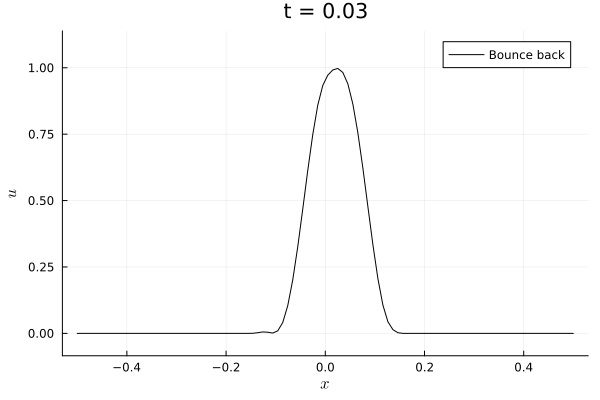

In [24]:
# Initial condition
center = 0.0
width = 0.125
u₀fun(x) = u_init(x, 2, center, width ) 

# Parameters
xmax = 0.5
xmin = -0.5
c = 0.5
Tf = 3.0  
Nₓ = 100
Nₜ = 150
s = 2.0

# Computation of the solutions
sol = solve(u₀fun, x -> advection(x, c); Nₜ = Nₜ, T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, collision! = bounce_back!)

# Creation of the animation
animation(sol_exact; d = 10, fps = 10, Lmax = xmax, Lmin = xmin, T = Tf, label = "Bounce back")

On remarque bien qe la solution est instable : elle explose sur le bord droit lorsque la solution y arrive et cette explosion se propage à tout le domaine.

### **3. Anti - Bounce back**

Introduisons la fonction qui permet d'effectuer la condition anti-bounce-back.

In [ ]:
function antibounce_back!(f::AbstractMatrix, λ::Real, c::Real)
    f[1,end] = -f[2,end-1]
    f[2,1]   = -f[1,2]
end

Affichons une animation pour visualiser les effets de cette condition anti-bounce-back.

In [ ]:
# Initial condition
center = 0.0
width = 0.125
u₀fun(x) = u_init(x, 2, center, width ) 

# Parameters
xmax = 0.5
xmin = -0.5
c = 0.5
Tf = 4.0  
Nₓ = 100
Nₜ = 300
s = 2.0

# Computation of the solutions
sol = solve(u₀fun, x -> advection(x, c); Nₜ = Nₜ, T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, collision! = antibounce_back!)

# Creation of the animation
animation(sol; d = 10, fps = 10, Lmax = xmax, Lmin = xmin, T = Tf, label = "Antibounce back")

On remarque tout d'abord que la solution est stable contrairement au cas précédent du bounce-back. On observe ensuite la chose suivante. Après avoir atteint le bord droit, la solution rebondit et parcours le domaine dans l'autre sens à la même vitesse. Pendant cette première phase, elle prend une autre forme : son amplitude est nettemet diminuée et ressemble à deux petits paques d'ondes comme si on avait codé sous une certaine forme notre signal d'entrée pour le transmettre à l'autre bord de la façon la plus discrète possible. Une fois l'autre bord atteint, la solution reprend sa forme de départ. Cette condition ressemble à une condition périodique où l'on avait aggrandit le domaine par deux et que l'on observait que sa moitié gauche. De ce fait, on retrouuve la condition initiale après un temps double par rapport à la condition périodique, ce qui entraine une plus forte amplitude de dépassement de la solution notamment dans le cas s=2.

Observons ce qui se passe pour différentes valeurs de $s$ et de $\lambda$ au cours de chacune de ces deux phases (après réflexion sur le bord droit et après réflexion sur le bord gauche).

In [ ]:
# Initial condition
center = 0.0
width = 0.125
u₀fun(x) = u_init(x, 2, center, width)  

# Parameters
xmax = 0.5
xmin = -0.5
c = 0.5
Tf = 4.0 
Nₓ = 256
s = 1.999
λ = 1.0
Δx = (xmax - xmin)/(Nₓ+1)
mesh = LinRange(xmin+0.5*Δx,xmax-0.5*Δx,Nₓ)

Array_s = Array_s = [1.0, 1.5, 1.9, 1.99, 1.999, 1.9999, 2.0]
Array_λ = [0.51, 0.55, 0.6, 1.0, 2.0]

# Resolution
sol_s = [solve(u₀fun, x -> advection(x, c); Nₜ = Nₜ = Int(round(Tf *Nₓ*λ)), T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, collision! = antibounce_back!) for s ∈ Array_s]
sol_λ = [solve(u₀fun, x -> advection(x, c); Nₜ = Nₜ = Int(round(Tf *Nₓ*λ)), T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, collision! = antibounce_back!) for λ ∈ Array_λ]

print("Computation done")

Commençons avec la première phase :

In [ ]:
# Plot

plt_λ = plot(label ="init", size = (900,400))
xlabel!(L"x")
ylabel!(L"u")
title!("λ = "*string(λ))
for i in reverse(eachindex(sol_s))
    plot!(mesh, sol_s[i][Int(round(end/2)),:], label = "s = "*string(Array_s[i]))
end

plt_s = plot(label ="init", size = (900,400))
xlabel!(L"x")
ylabel!(L"u")
title!("s = "*string(s))
for i in eachindex(sol_λ)
    plot!(mesh, sol_λ[i][Int(round(end/2)),:], label = "λ = "*string(Array_λ[i]))
end

plot(plt_λ, plt_s, layout = (1,2), size = (1200,500), color = :red, margin = 0.5Plots.cm)

Il n'est pas facile de lire ces graphiques à cause de superpositions quasiment-parfaites partielles mais en regardant on peut faire les remarques suivantes. On remarque que l'ampitude du "signal transformé" est d'autant plus grande que $s$ est proche de 2, ainsi que $\lambda$ est proche de 0.5. En anticipant le graphique suivant montrant la deuxième phase, on voit que l'aténuation du signal pendant la deuxième phase est donc décroissante avec l'amplitude du signal de la première phase. On remarque que plus s est petit moins on peut die qu'il y un signal retour. On observe de plus une très forte variation de l'ampitude entre $s=1.99$ et $s=1.999$ ce qui est assez étonnant.

In [ ]:
# Plot

plt_λ = plot(mesh, u₀fun(mesh), label ="init", size = (900,400), c=:black, ylim = [-0.2, 1.1])
xlabel!(L"x")
ylabel!(L"u")
title!("λ = "*string(λ))
for i in eachindex(sol_s)
    scatter!(mesh, sol_s[i][end,:], label = "s = "*string(Array_s[i]), markershape=:circle, ma = 0.5,)
end

plt_s = plot(mesh, u₀fun(mesh), label ="init", size = (900,400), c=:black, ylim = [-0.2, 1.1])
xlabel!(L"x")
ylabel!(L"u")
title!("s = "*string(s))
for i in eachindex(sol_λ)
    scatter!(mesh, sol_λ[i][end,:], label = "λ = "*string(Array_λ[i]), markershape=:circle, ma = 0.5)
end

plot(plt_λ, plt_s, layout = (1,2), size = (1200,500), color = :red, margin = 0.5Plots.cm)

On remarque que l'atténuation pour revenir au point de départ est très forte pour des $s$ très légèrmeent inféireur à 2 et impose alors une valeur de $s$ égale à quasiment 2 à $\lambda$ fixée. A $s$ fixé, on peut diminuer la diffusion en faisant tendre la valeur de $\lambda$ vers $c$ (par valeurs supérieures) mais que de façon limité si $s ≠ 2$. Il faut donc impérativement $s=2$ dans le cas général pour garantir une faible atténuation, mais cela impose quelques dépassements de la solution (i.e ne pas respecter le principe du maximum). POur des valeurs de $s$ petite, par xemple autour de $s=1$, on n'observe pas de signal retour.

Ainsi, lorsque $s =2$ (ou s très très très proche de 2 et encore cela dépend de la valeur de $\lambda$), la conditoin anti-ounce-back est une bonne condition d'entrée et meilleur que pour $s$ plus petit (par exemple 1), mais une condition de sortie pas très satisfaisante car on observe des amplitudes de l'ordre de $3%$ de l'amplitude maximale de la condition initiale. Pour des valeurs de $s$ plus petites (par exemple 1) la condition de sortie semble bonne mais prendre un tel $s$ implique une forte atténuation de la solution avant même le premier contact aec le bord du domaine ce qui en fait une solution non acceptable. Les défauts concernant la conditon de sortie dans le cas $s≈ 1$ et $s=2$ peuvent être résolus, au prix de plus de temps de calculs, en diminuant les pas de temps et d'espace : on augmentera la précision avant le premier contact pour $s=1$ et on diminuera les amplitudes "parasites" pour $s=2$. Vérifions cela par deux animations: 

In [ ]:
# Initial condition
center = 0.0
width = 0.125
u₀fun(x) = u_init(x, 2, center, width ) 

# Parameters
xmax = 0.5
xmin = -0.5
c = 0.5
Tf = 4.0  
Nₓ = 1000
Nₜ = 3000
s = 2.0

# Computation of the solutions
sol = solve(u₀fun, x -> advection(x, c); Nₜ = Nₜ, T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, collision! = antibounce_back!)

# Creation of the animation
animation(sol; d = 10, fps = 10, Lmax = xmax, Lmin = xmin, T = Tf, label = "Antibounce back")

L'ampitude pendant la première phase est nettement diminuée et le signal a presque disparu.

In [ ]:
# Initial condition
center = 0.0
width = 0.125
u₀fun(x) = u_init(x, 2, center, width ) 

# Parameters
xmax = 0.5
xmin = -0.5
c = 0.5
Tf = 4.0  
Nₓ = 1000
Nₜ = 3000
s = 1.0

# Computation of the solutions
sol = solve(u₀fun, x -> advection(x, c); Nₜ = Nₜ, T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, collision! = antibounce_back!)

# Creation of the animation
animation(sol; d = 10, fps = 10, Lmax = xmax, Lmin = xmin, T = Tf, label = "Antibounce back")

On remarque maintenant que pour $s=1$, la condtion anti-bounce-back est une excellente conditoin de sortie, sous réserve d'une faible atténuation de la solution avant le contact avec le bord, i.e un compromis entre distance au bord et vitesse $c$ de la solution.

### **4. Copy Condition**

Introduisons la fonction qui permet d'effectuer la condition copy.

In [ ]:
function copy_condition!(f::AbstractMatrix, λ::Real, c::Real)
    f[1,end] = f[1,end-1]
    f[2,1]   = f[2,2]
end

Affichons une animation pour visualiser les effets de cette condition copy.

In [ ]:
# Initial condition
center = 0.0
width = 0.125
u₀fun(x) = u_init(x, 2, center, width ) 

# Parameters
xmax = 0.5
xmin = -0.5
c = 0.5
Tf = 4.0  
Nₓ = 100
Nₜ = 300
s = 2.0

# Computation of the solutions
sol = solve(u₀fun, x -> advection(x, c); Nₜ = Nₜ, T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, collision! = copy_condition!)

# Creation of the animation
animation(sol; d = 10, fps = 10, Lmax = xmax, Lmin = xmin, T = Tf, label = "Copy condition")

In [ ]:
# Initial condition
center = 0.0
width = 0.125
u₀fun(x) = u_init(x, 2, center, width)  

# Parameters
xmax = 0.5
xmin = -0.5
c = 0.5
Tf = 4.0 
Nₓ = 256
s = 2.0
λ = 4.0
Δx = (xmax - xmin)/(Nₓ+1)
mesh = LinRange(xmin+0.5*Δx,xmax-0.5*Δx,Nₓ)

Array_s =  [1.0, 1.5, 1.9, 1.99, 1.999, 1.9999, 2.0]
Array_λ = [0.51, 0.55, 0.6, 1.0, 2.0, 4.0, 10.0, 100.0]

# Resolution
sol_s = [solve(u₀fun, x -> advection(x, c); Nₜ = Nₜ = Int(round(Tf *Nₓ*λ)), T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, collision! = copy_condition!) for s ∈ Array_s]
sol_λ = [solve(u₀fun, x -> advection(x, c); Nₜ = Nₜ = Int(round(Tf *Nₓ*λ)), T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, collision! = copy_condition!) for λ ∈ Array_λ]

# Plot

plt_λ = plot(mesh, u₀fun(mesh), label ="init", size = (900,400), c=:black, ylim = [-1.1, 1.1])
xlabel!(L"x")
ylabel!(L"u")
title!("λ = "*string(λ))
for i in eachindex(sol_s)
    scatter!(mesh, sol_s[i][end,:], label = "s = "*string(Array_s[i]), markershape=:circle, ma = 0.5,)
end

plt_s = plot(mesh, u₀fun(mesh), label ="init", size = (900,400), c=:black, ylim = [-1.1, 1.1])
xlabel!(L"x")
ylabel!(L"u")
title!("s = "*string(s))
for i in eachindex(sol_λ)
    scatter!(mesh, sol_λ[i][end,:], label = "λ = "*string(Array_λ[i]), markershape=:circle, ma = 0.5)
end

plot(plt_λ, plt_s, layout = (1,2), size = (1200,500), color = :red, margin = 0.5Plots.cm)

### **5. Condition sortante**

Introduisons la fonction qui permet d'effectuer la condition sortante.

In [7]:
function sortante!(f::AbstractMatrix, λ::Real, c::Real)
    f[1,end] = (λ-c)/(λ + c) * f[2,end-1]
    f[2,1]   = -f[1,2]
end

sortante! (generic function with 1 method)

Affichons une animation pour visualiser les effets de cette condition copy.

┌ Info: Saved animation to C:\Users\theoz\AppData\Local\Temp\jl_Wd8RMbITAn.gif
└ @ Plots C:\Users\theoz\.julia\packages\Plots\Pe7wF\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\theoz\\AppData\\Local\\Temp\\jl_Wd8RMbITAn.gif")
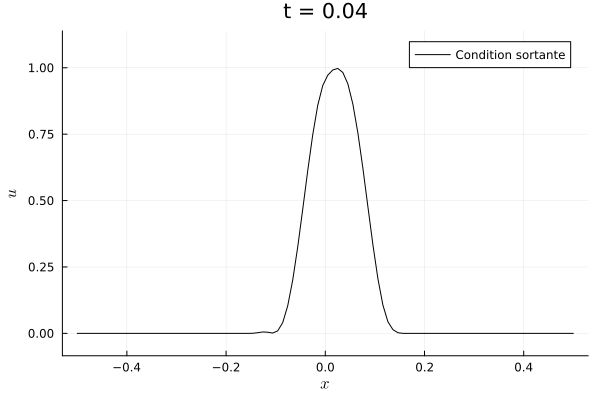

In [8]:
# Initial condition
center = 0.0
width = 0.125
u₀fun(x) = u_init(x, 2, center, width ) 

# Parameters
xmax = 0.5
xmin = -0.5
c = 0.5
Tf = 4.0  
Nₓ = 100
s = 2.0
λ = 0.75

# Computation of the solutions
sol_exact = solve(u₀fun, x -> advection(x, c); λ = λ, T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, collision! = sortante!)[1]

# Creation of the animation
animation(sol_exact; d = 10, fps = 10, Lmax = xmax, Lmin = xmin, T = Tf, label = "Condition sortante")

On remarque que la condition sortante, comme son nom l'indique, permet de simuler la sortie du domaine de la solution. Comme pour la condition anti-bounce-back, il y a deux phases. Tout d'abord, la solution touche le bord droit du domaine et seul un bruit persiste dans le domaine, puis une onde très aténuée formée que de quelques bosses rentre dans le domaine par le bord gauche. Tout se passe comme pour la condition anti-bounce-back, à la différence que l'on observe pas vraiment d'onde dans la phase 1, seulement un bruit presque inperceptible et que la phase 2 n'a pas pour but de refaire apparaitre la solution.

S'il est clair que la première phase avec du bruit très faible ne présente pas défaut par rapport à l'objectif voulue, qui est de simuler la sortie de la solution du domaine, il faut cependant étudier les ondes générées pendant la deuxième phase et voir si leurs amplitudes sont suffisament faibles.

Observons ce qui se passe pour différentes valeurs de $s$ et de $\lambda$ au cours de chacune de ces deux phases (après réflexion sur le bord droit et après réflexion sur le bord gauche).

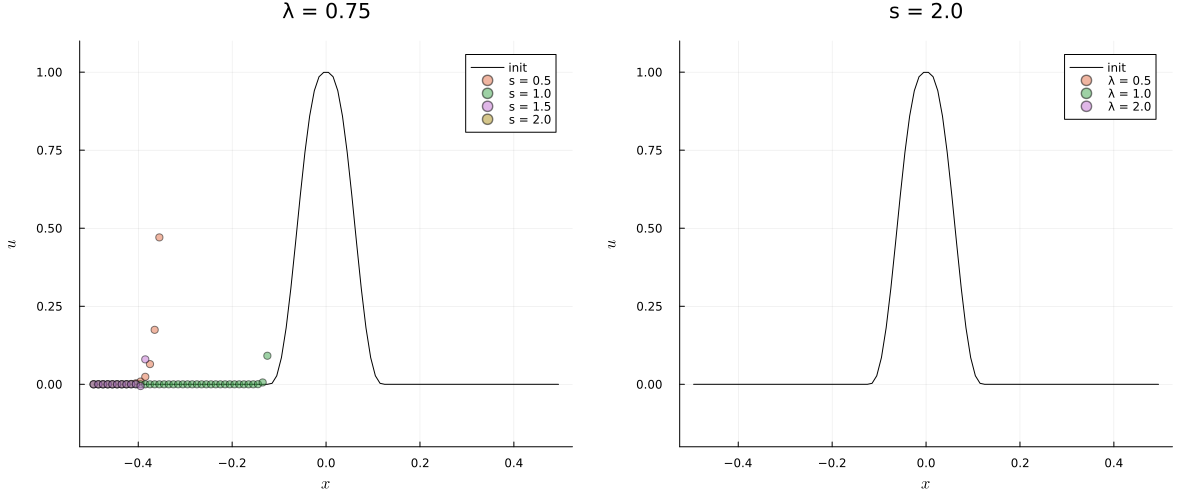

In [18]:
# Initial condition
center = 0.0
width = 0.125
u₀fun(x) = u_init(x, 2, center, width)  

# Parameters
xmax = 0.5
xmin = -0.5
c = 0.5
Tf = 3.0 
Nₓ = 100
s = 2.0
λ = 0.75
Δx = (xmax - xmin)/(Nₓ+1)
mesh = LinRange(xmin+0.5*Δx,xmax-0.5*Δx,Nₓ)

Array_s = Array_s = [0.5, 1.0, 1.5, 2.0]
Array_λ = [0.5, 1.0, 2.0]

# Resolution
sol_s = [solve(u₀fun, x -> advection(x, c); Nₜ = Nₜ = Int(round(Tf *Nₓ*λ)), T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, collision! = sortante!) for s ∈ Array_s]
sol_λ = [solve(u₀fun, x -> advection(x, c); Nₜ = Nₜ = Int(round(Tf *Nₓ*λ)), T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, collision! = sortante!) for λ ∈ Array_λ]

# Plot

plt_λ = plot(mesh, u₀fun(mesh), label ="init", size = (900,400), c=:black, ylim = [-0.2, 1.1])
xlabel!(L"x")
ylabel!(L"u")
title!("λ = "*string(λ))
for i in eachindex(sol_s)
    scatter!(mesh, sol_s[i][end,:], label = "s = "*string(Array_s[i]), markershape=:circle, ma = 0.5,)
end

plt_s = plot(mesh, u₀fun(mesh), label ="init", size = (900,400), c=:black, ylim = [-0.2, 1.1])
xlabel!(L"x")
ylabel!(L"u")
title!("s = "*string(s))
for i in eachindex(sol_λ)
    scatter!(mesh, sol_λ[i][end,:], label = "λ = "*string(Array_λ[i]), markershape=:circle, ma = 0.5)
end

plot(plt_λ, plt_s, layout = (1,2), size = (1200,500), color = :red, margin = 0.5Plots.cm)

## **Exercice 2 : Equation de Burgers**

Dans cette partie, on se concentre sur l'équation de Burgers.

In [20]:
# Advection
burgers(u::Real) = 0.5*u^2

burgers (generic function with 2 methods)

### **1. Condition périodique**

Affichons une animation pour visualiser les effets de cette condition périodique.

┌ Info: Saved animation to C:\Users\theoz\AppData\Local\Temp\jl_UlKh4dg3Ox.gif
└ @ Plots C:\Users\theoz\.julia\packages\Plots\Pe7wF\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\theoz\\AppData\\Local\\Temp\\jl_UlKh4dg3Ox.gif")
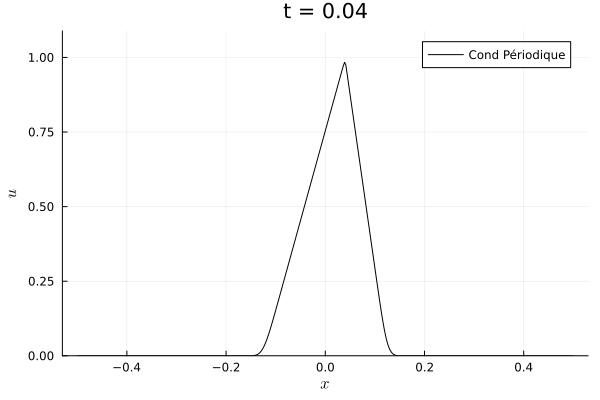

In [35]:
# Initial condition
center = 0.0
width = 0.125
u₀fun(x) = solution(x, 0.0; middle = center, width = width) 

# Parameters
xmax = 0.5
xmin = -0.5
c = 0.5
Tf = 4.0  
Nₓ = 400
λ = 1.0
s = 1.0

# Computation of the solutions
sol = solve(u₀fun, burgers; λ = λ, T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, collision! = periodic!)[1]

# Creation of the animation
animation(sol; d = 10, fps = 10, Lmax = xmax, Lmin = xmin, T = Tf, label = "Cond Périodique")

On remarque que contrairement au cas de l'advection où l'on avait pris u ne condition initiale à support compact et qui reste à support compact sous l'effet d'advecrtion, ici le support de la solution s'étend avec la solution et le front dela oslution finit par rejoindre la queue de la solution : ici la solution n'est plus périodique avec le temps.

Observons ce qui se passe pour différentes valeurs de $s$ et de $\lambda$.

In [38]:
# Initial condition
center = 0.0
width = 0.125
u₀fun(x) = solution(x, 0.0; middle = center, width = width) 

# Parameters
xmax = 0.5
xmin = -0.5
c = 0.5
Tf = 4.0  
Nₓ = 400
λ = 1.0
s = 1.0
Δx = (xmax - xmin)/(Nₓ+1)
mesh = LinRange(xmin+0.5*Δx,xmax-0.5*Δx,Nₓ)

Array_s = Array_s = [0.5, 1.0, 1.5, 2.0]
Array_λ = [0.5, 1.0, 2.0]

# Resolution
sol_s = [solve(u₀fun, burgers; Nₜ = Nₜ = Int(round(Tf *Nₓ*λ)), T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, collision! = periodic!) for s ∈ Array_s]
sol_λ = [solve(u₀fun, burgers; Nₜ = Nₜ = Int(round(Tf *Nₓ*λ)), T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, collision! = periodic!) for λ ∈ Array_λ]

# Plot

plt_λ = plot(label ="init", size = (900,400), ylim = [-0.2, 1.1])
xlabel!(L"x")
ylabel!(L"u")
title!("λ = "*string(λ))
for i in eachindex(sol_s)
    scatter!(mesh, sol_s[i][end,:], label = "s = "*string(Array_s[i]), markershape=:circle, ma = 0.5,)
end

plt_s = plot(label ="init", size = (900,400), ylim = [-0.2, 1.1])
xlabel!(L"x")
ylabel!(L"u")
title!("s = "*string(s))
for i in eachindex(sol_λ)
    scatter!(mesh, sol_λ[i][end,:], label = "λ = "*string(Array_λ[i]), markershape=:circle, ma = 0.5)
end

plot(plt_λ, plt_s, layout = (1,2), size = (1200,500), color = :red, margin = 0.5Plots.cm)

Sans grande surprise, le comportement est similaire à celui sans condition de bords. On peut toutefois se demander si la condition périodique ne réduit pas l'ordre de convergence. Par exemple, si la condtion périodique est une approximation à l'ordre 1, alors il y aura réduction de la convergence d'ordre 2 fournit dans le cas $s=2$.

In [ ]:
# Initial condition
center = 0.0
width = 0.125
u₀fun(x) = u_init(x, 2, center, width)  

# Parameters
xmax = 0.5
xmin = -0.5
c = 0.5
Tf = 2.0 
λ = 0.6

# Different value of s
Array_s = Array_s = [0.5, 1.0, 1.5, 2.0]

# Variation of the parameter $Δx$ : 
pNₓ= range(3,9)
base = 2.0
ArrayNₓ = Int.(round.( base  .^ pNₓ))

# Resolution
Arraysol = [[solve(u₀fun, x -> advection(x, c); T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, λ = λ, collision! = periodic!) for Nₓ ∈ ArrayNₓ] for s ∈ Array_s]
real_T = [[sol[2] for sol ∈ Arraysol[i]] for i ∈ eachindex(Arraysol)]

# Exact solution
sol_exact = [[u₀fun(mod.(LinRange(xmin+0.5*(xmax - xmin)/(Nₓ+1), xmax-0.5*(xmax - xmin)/(Nₓ+1),Nₓ) .- c* T .- xmin, xmax-xmin) .+ xmin ) for (Nₓ,T) ∈ zip(ArrayNₓ, real_T[i])] for i ∈ eachindex(real_T)]

# Computation of the error
erreur = [[sqrt((xmax-xmin)/(ArrayNₓ[j]-1))*norm(sol_exact[i][j][1:end-1] .- Arraysol[i][j][1][end,1:end-1]) for j ∈ eachindex(ArrayNₓ)] for i ∈ eachindex(Arraysol)]

print("Error computed")

In [ ]:
# Function to plot straight curve
courbe(pente::Real, x::Real, y::Real, span::AbstractVector) = (-pente*x + y) .+ pente .* span

# Plot
plot(margin = 0.5Plots.cm, size = (900,400))
plot!(pNₓ, courbe(-1, 5, log(erreur[1][3])./log(base), pNₓ) , label ="ref ordre 1", size = (900,400), c=:red)
plot!(pNₓ, courbe(-2, 5, log(erreur[1][3])./log(base), pNₓ) , label ="ref ordre 2", size = (900,400), c=:blue)
for (e,s) ∈ zip(erreur, Array_s) 
    plot!(pNₓ, log.(e[eachindex(pNₓ)]) ./ log(base), label ="s = "*string(s), shape =:x)
end
xlabel!(L"log(N_x)")
ylabel!(L"log(Erreur)")
title!("Convergence du schéma en espace")

### **2. Bounce back**

Introduisons la fonction qui permet d'effectuer la condition bounce-back.

In [ ]:
function bounce_back!(f::AbstractMatrix, λ::Real, c::Real)
    f[1,end] = f[2,end-1]
    f[2,1]   = f[1,2]
end

Affichons une animation pour visualiser les effets de cette condition bounce-back.

In [ ]:
# Initial condition
center = 0.0
width = 0.125
u₀fun(x) = u_init(x, 2, center, width ) 

# Parameters
xmax = 0.5
xmin = -0.5
c = 0.5
Tf = 3.0  
Nₓ = 100
Nₜ = 150
s = 2.0

# Computation of the solutions
sol = solve(u₀fun, x -> advection(x, c); Nₜ = Nₜ, T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, collision! = bounce_back!)

# Creation of the animation
animation(sol_exact; d = 10, fps = 10, Lmax = xmax, Lmin = xmin, T = Tf, label = "Bounce back")

On remarque bien qe la solution est instable : elle explose sur le bord droit lorsque la solution y arrive et cette explosion se propage à tout le domaine.

### **3. Anti - Bounce back**

Introduisons la fonction qui permet d'effectuer la condition anti-bounce-back.

In [ ]:
function antibounce_back!(f::AbstractMatrix, λ::Real, c::Real)
    f[1,end] = -f[2,end-1]
    f[2,1]   = -f[1,2]
end

Affichons une animation pour visualiser les effets de cette condition anti-bounce-back.

In [ ]:
# Initial condition
center = 0.0
width = 0.125
u₀fun(x) = u_init(x, 2, center, width ) 

# Parameters
xmax = 0.5
xmin = -0.5
c = 0.5
Tf = 4.0  
Nₓ = 100
Nₜ = 300
s = 2.0

# Computation of the solutions
sol = solve(u₀fun, x -> advection(x, c); Nₜ = Nₜ, T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, collision! = antibounce_back!)

# Creation of the animation
animation(sol; d = 10, fps = 10, Lmax = xmax, Lmin = xmin, T = Tf, label = "Antibounce back")

On remarque tout d'abord que la solution est stable contrairement au cas précédent du bounce-back. On observe ensuite la chose suivante. Après avoir atteint le bord droit, la solution rebondit et parcours le domaine dans l'autre sens à la même vitesse. Pendant cette première phase, elle prend une autre forme : son amplitude est nettemet diminuée et ressemble à deux petits paques d'ondes comme si on avait codé sous une certaine forme notre signal d'entrée pour le transmettre à l'autre bord de la façon la plus discrète possible. Une fois l'autre bord atteint, la solution reprend sa forme de départ. Cette condition ressemble à une condition périodique où l'on avait aggrandit le domaine par deux et que l'on observait que sa moitié gauche. De ce fait, on retrouuve la condition initiale après un temps double par rapport à la condition périodique, ce qui entraine une plus forte amplitude de dépassement de la solution notamment dans le cas s=2.

Observons ce qui se passe pour différentes valeurs de $s$ et de $\lambda$ au cours de chacune de ces deux phases (après réflexion sur le bord droit et après réflexion sur le bord gauche).

In [ ]:
# Initial condition
center = 0.0
width = 0.125
u₀fun(x) = u_init(x, 2, center, width)  

# Parameters
xmax = 0.5
xmin = -0.5
c = 0.5
Tf = 4.0 
Nₓ = 256
s = 1.999
λ = 1.0
Δx = (xmax - xmin)/(Nₓ+1)
mesh = LinRange(xmin+0.5*Δx,xmax-0.5*Δx,Nₓ)

Array_s = Array_s = [1.0, 1.5, 1.9, 1.99, 1.999, 1.9999, 2.0]
Array_λ = [0.51, 0.55, 0.6, 1.0, 2.0]

# Resolution
sol_s = [solve(u₀fun, x -> advection(x, c); Nₜ = Nₜ = Int(round(Tf *Nₓ*λ)), T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, collision! = antibounce_back!) for s ∈ Array_s]
sol_λ = [solve(u₀fun, x -> advection(x, c); Nₜ = Nₜ = Int(round(Tf *Nₓ*λ)), T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, collision! = antibounce_back!) for λ ∈ Array_λ]

print("Computation done")

Commençons avec la première phase :

In [ ]:
# Plot

plt_λ = plot(label ="init", size = (900,400))
xlabel!(L"x")
ylabel!(L"u")
title!("λ = "*string(λ))
for i in reverse(eachindex(sol_s))
    plot!(mesh, sol_s[i][Int(round(end/2)),:], label = "s = "*string(Array_s[i]))
end

plt_s = plot(label ="init", size = (900,400))
xlabel!(L"x")
ylabel!(L"u")
title!("s = "*string(s))
for i in eachindex(sol_λ)
    plot!(mesh, sol_λ[i][Int(round(end/2)),:], label = "λ = "*string(Array_λ[i]))
end

plot(plt_λ, plt_s, layout = (1,2), size = (1200,500), color = :red, margin = 0.5Plots.cm)

Il n'est pas facile de lire ces graphiques à cause de superpositions quasiment-parfaites partielles mais en regardant on peut faire les remarques suivantes. On remarque que l'ampitude du "signal transformé" est d'autant plus grande que $s$ est proche de 2, ainsi que $\lambda$ est proche de 0.5. En anticipant le graphique suivant montrant la deuxième phase, on voit que l'aténuation du signal pendant la deuxième phase est donc décroissante avec l'amplitude du signal de la première phase. On remarque que plus s est petit moins on peut die qu'il y un signal retour. On observe de plus une très forte variation de l'ampitude entre $s=1.99$ et $s=1.999$ ce qui est assez étonnant.

In [ ]:
# Plot

plt_λ = plot(mesh, u₀fun(mesh), label ="init", size = (900,400), c=:black, ylim = [-0.2, 1.1])
xlabel!(L"x")
ylabel!(L"u")
title!("λ = "*string(λ))
for i in eachindex(sol_s)
    scatter!(mesh, sol_s[i][end,:], label = "s = "*string(Array_s[i]), markershape=:circle, ma = 0.5,)
end

plt_s = plot(mesh, u₀fun(mesh), label ="init", size = (900,400), c=:black, ylim = [-0.2, 1.1])
xlabel!(L"x")
ylabel!(L"u")
title!("s = "*string(s))
for i in eachindex(sol_λ)
    scatter!(mesh, sol_λ[i][end,:], label = "λ = "*string(Array_λ[i]), markershape=:circle, ma = 0.5)
end

plot(plt_λ, plt_s, layout = (1,2), size = (1200,500), color = :red, margin = 0.5Plots.cm)

On remarque que l'atténuation pour revenir au point de départ est très forte pour des $s$ très légèrmeent inféireur à 2 et impose alors une valeur de $s$ égale à quasiment 2 à $\lambda$ fixée. A $s$ fixé, on peut diminuer la diffusion en faisant tendre la valeur de $\lambda$ vers $c$ (par valeurs supérieures) mais que de façon limité si $s ≠ 2$. Il faut donc impérativement $s=2$ dans le cas général pour garantir une faible atténuation, mais cela impose quelques dépassements de la solution (i.e ne pas respecter le principe du maximum). POur des valeurs de $s$ petite, par xemple autour de $s=1$, on n'observe pas de signal retour.

Ainsi, lorsque $s =2$ (ou s très très très proche de 2 et encore cela dépend de la valeur de $\lambda$), la conditoin anti-ounce-back est une bonne condition d'entrée et meilleur que pour $s$ plus petit (par exemple 1), mais une condition de sortie pas très satisfaisante car on observe des amplitudes de l'ordre de $3%$ de l'amplitude maximale de la condition initiale. Pour des valeurs de $s$ plus petites (par exemple 1) la condition de sortie semble bonne mais prendre un tel $s$ implique une forte atténuation de la solution avant même le premier contact aec le bord du domaine ce qui en fait une solution non acceptable. Les défauts concernant la conditon de sortie dans le cas $s≈ 1$ et $s=2$ peuvent être résolus, au prix de plus de temps de calculs, en diminuant les pas de temps et d'espace : on augmentera la précision avant le premier contact pour $s=1$ et on diminuera les amplitudes "parasites" pour $s=2$. Vérifions cela par deux animations: 

In [ ]:
# Initial condition
center = 0.0
width = 0.125
u₀fun(x) = u_init(x, 2, center, width ) 

# Parameters
xmax = 0.5
xmin = -0.5
c = 0.5
Tf = 4.0  
Nₓ = 1000
Nₜ = 3000
s = 2.0

# Computation of the solutions
sol = solve(u₀fun, x -> advection(x, c); Nₜ = Nₜ, T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, collision! = antibounce_back!)

# Creation of the animation
animation(sol; d = 10, fps = 10, Lmax = xmax, Lmin = xmin, T = Tf, label = "Antibounce back")

L'ampitude pendant la première phase est nettement diminuée et le signal a presque disparu.

In [ ]:
# Initial condition
center = 0.0
width = 0.125
u₀fun(x) = u_init(x, 2, center, width ) 

# Parameters
xmax = 0.5
xmin = -0.5
c = 0.5
Tf = 4.0  
Nₓ = 1000
Nₜ = 3000
s = 1.0

# Computation of the solutions
sol = solve(u₀fun, x -> advection(x, c); Nₜ = Nₜ, T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, collision! = antibounce_back!)

# Creation of the animation
animation(sol; d = 10, fps = 10, Lmax = xmax, Lmin = xmin, T = Tf, label = "Antibounce back")

On remarque maintenant que pour $s=1$, la condtion anti-bounce-back est une excellente conditoin de sortie, sous réserve d'une faible atténuation de la solution avant le contact avec le bord, i.e un compromis entre distance au bord et vitesse $c$ de la solution.